# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# V2

In [49]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity
from inverse_modelling_tfo.misc.misc_training import set_seed
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [50]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, -1])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,10,-4.999507,1.0,6.0,12.0,0.9,0.11,0.1
1,14,-7.171885,1.0,6.0,12.0,0.9,0.11,0.1
2,19,-9.277114,1.0,6.0,12.0,0.9,0.11,0.1
3,23,-10.143018,1.0,6.0,12.0,0.9,0.11,0.1
4,28,-10.149250,1.0,6.0,12.0,0.9,0.11,0.1


In [51]:
# data1 = create_ratio(data, True)
# data2 = create_spatial_intensity(data)
# sim_params = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Fetal Hb Concentration", "Fetal Saturation", "Maternal Saturation"]
# data = pd.merge(data1, data2, how='inner', on=sim_params)

# data = create_ratio(data, True)

data = create_spatial_intensity(data)

data.head() 
# NOTE: Have only 1 on at the same time!

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.784362,-5.887022,-6.560915,-7.015157,-7.712442,...,-19.639869,-22.003357,-25.265887,-28.112349,-31.952534,-35.240710,-39.608559,-43.300212,-48.150422,-52.211376
1,2.0,12.0,0.9,0.11,0.225,-4.783804,-5.882596,-6.550246,-6.998650,-7.687817,...,-19.677858,-22.046210,-25.314961,-28.166499,-32.013139,-35.306559,-39.681050,-43.378082,-48.235089,-52.301534
2,2.0,12.0,0.9,0.11,0.350,-4.783210,-5.877882,-6.538860,-6.980969,-7.661314,...,-19.715011,-22.088109,-25.362928,-28.219417,-32.072350,-35.370881,-39.751845,-43.454117,-48.317744,-52.389537
3,2.0,12.0,0.9,0.11,0.475,-4.782576,-5.872834,-6.526638,-6.961915,-7.632599,...,-19.751362,-22.129094,-25.409836,-28.271155,-32.130227,-35.433740,-39.821015,-43.528395,-48.398473,-52.475475
4,2.0,12.0,0.9,0.11,0.600,-4.781896,-5.867394,-6.513429,-6.941227,-7.601231,...,-19.786945,-22.169203,-25.455727,-28.321760,-32.186822,-35.495197,-39.888626,-43.600986,-48.477353,-52.559433


In [52]:
# Cleanup
data.dropna(inplace=True)
data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.784362,-5.887022,-6.560915,-7.015157,-7.712442,...,-19.639869,-22.003357,-25.265887,-28.112349,-31.952534,-35.240710,-39.608559,-43.300212,-48.150422,-52.211376
1,2.0,12.0,0.9,0.11,0.225,-4.783804,-5.882596,-6.550246,-6.998650,-7.687817,...,-19.677858,-22.046210,-25.314961,-28.166499,-32.013139,-35.306559,-39.681050,-43.378082,-48.235089,-52.301534
2,2.0,12.0,0.9,0.11,0.350,-4.783210,-5.877882,-6.538860,-6.980969,-7.661314,...,-19.715011,-22.088109,-25.362928,-28.219417,-32.072350,-35.370881,-39.751845,-43.454117,-48.317744,-52.389537
3,2.0,12.0,0.9,0.11,0.475,-4.782576,-5.872834,-6.526638,-6.961915,-7.632599,...,-19.751362,-22.129094,-25.409836,-28.271155,-32.130227,-35.433740,-39.821015,-43.528395,-48.398473,-52.475475
4,2.0,12.0,0.9,0.11,0.600,-4.781896,-5.867394,-6.513429,-6.941227,-7.601231,...,-19.786945,-22.169203,-25.455727,-28.321760,-32.186822,-35.495197,-39.888626,-43.600986,-48.477353,-52.559433


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [53]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
y_column = 'Fetal Hb Concentration'
fixed_columns = ['Maternal Wall Thickness', "Fetal Saturation", "Maternal Saturation"]
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
# x_columns = list(filter(lambda X: '_' in X, data.columns))
# x_columns = list(filter(lambda X: X.isdigit(), data.columns))
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))



## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_column] = y_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1))

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])
## Manual scale - if needed (With maternal info.)
# data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns[:-2]] += 0.5  # unit var, 0 mean

## Scale non-intensity x columns (Maternal Hb Conc. , Maternal Saturation)
# data["Maternal Saturation"] -= 0.5 
# data["Maternal Hb Concentration"] /= 20
# data["Maternal Hb Concentration"] -= 0.5 


In [54]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.14]
Y scale var [0.00045]


In [55]:
data[y_column].value_counts()

-1.414214    375
-0.707107    375
 0.000000    375
 0.707107    375
 1.414214    375
Name: Fetal Hb Concentration, dtype: int64

## Model Configuration

In [56]:
IN_FEATURES = len(x_columns) * 2
OUT_FEATURES = 1
model_config = {
    'model_class' : SplitChannelCNN,  # Class name
    # 'model_class' : PerceptronReLU,  # Class name
    # 'model_params' :  [2, IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 5, [6, 3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 7, [3, OUT_FEATURES]],    # Input params as an array
    'model_params' :  [4, IN_FEATURES, 8, 7, [4, 2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [[IN_FEATURES, 20, 8, OUT_FEATURES]],    # Input params as an array
    'train_split' : 0.8,
    'epochs' : 25,
    'total_data_len': 40000,
    'allow_zero_diff': False,
    'hyperparam_search_count': 50,
    'hyperparam_max_epoch': 10,
    'seed': 42
}

In [57]:
# Custom Train Function 
def train_model2(iteration_config, epoch=model_config['hyperparam_max_epoch']):
    set_seed(model_config['seed'])
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    # train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [58]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.93, 0.95, 0.97]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=model_config['hyperparam_search_count'], resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


== Status ==
Current time: 2023-07-16 18:03:54 (running for 00:00:00.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-16_18-03-53
Number of trials: 50/50 (49 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+------------|
| train_model2_cca18_00000 | RUNNING  | 169.237.32.34:3478709 |           16 | 1.01604e-05 |       0.95 |
| train_model2_cca18_00001 | PENDING  |                       |           32 | 1.68067e-05 |       0.95 |
| train_model2_cca18_00002 | PENDING  |                       |          

Trial name,combined_loss,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_cca18_00000,4.3497,2023-07-16_18-05-13,True,,blueberry,5,169.237.32.34,3478709,77.9551,15.7477,77.9551,1689555913,2.06437,5,cca18_00000,2.10704
train_model2_cca18_00001,4.28174,2023-07-16_18-04-40,True,,blueberry,5,169.237.32.34,3478762,43.52,8.30632,43.52,1689555880,2.05694,5,cca18_00001,2.08161
train_model2_cca18_00002,0.815553,2023-07-16_18-06-35,True,"2_batch_size=16,lr=0.0001,momentum=0.9300",blueberry,10,169.237.32.34,3478764,158.088,15.7042,158.088,1689555995,1.012,10,cca18_00002,0.805882
train_model2_cca18_00003,4.29295,2023-07-16_18-05-18,True,,blueberry,5,169.237.32.34,3478766,81.5485,15.7908,81.5485,1689555918,2.05404,5,cca18_00003,2.09001
train_model2_cca18_00004,0.00335364,2023-07-16_18-06-35,True,"4_batch_size=16,lr=0.0003,momentum=0.9700",blueberry,10,169.237.32.34,3478768,158.678,15.4455,158.678,1689555995,0.0706934,10,cca18_00004,0.0474392
train_model2_cca18_00005,0.00378521,2023-07-16_18-05-20,True,"5_batch_size=32,lr=0.0001,momentum=0.9700",blueberry,10,169.237.32.34,3478770,82.8187,7.36667,82.8187,1689555920,0.0742072,10,cca18_00005,0.0510086
train_model2_cca18_00006,4.35831,2023-07-16_18-05-19,True,,blueberry,10,169.237.32.34,3478772,82.7059,7.4478,82.7059,1689555919,2.03717,10,cca18_00006,2.13939
train_model2_cca18_00007,4.34317,2023-07-16_18-05-18,True,,blueberry,5,169.237.32.34,3478774,81.0267,15.4778,81.0267,1689555918,2.06328,5,cca18_00007,2.10498
train_model2_cca18_00008,0.00178087,2023-07-16_18-09-10,True,"8_batch_size=8,lr=0.0003,momentum=0.9500",blueberry,10,169.237.32.34,3478776,313.775,30.5061,313.775,1689556150,0.0527425,10,cca18_00008,0.0337653
train_model2_cca18_00009,4.19794,2023-07-16_18-06-36,True,,blueberry,5,169.237.32.34,3478781,159.495,31.2173,159.495,1689555996,2.01909,5,cca18_00009,2.07912


== Status ==
Current time: 2023-07-16 18:04:14 (running for 00:00:20.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-16_18-03-53
Number of trials: 50/50 (34 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_cca18_00000 | RUNNING  | 169.237.32.34:3478709 

2023-07-16 18:11:25,685	INFO tune.py:945 -- Total run time: 451.72 seconds (451.69 seconds for the tuning loop).


== Status ==
Current time: 2023-07-16 18:11:25 (running for 00:07:31.70)
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.009347991964374752 | Iter 5.000: -2.755362920406008
Logical resource usage: 0/64 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-16_18-03-53
Number of trials: 50/50 (50 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_cca18_00000 | TERMINATED | 169.237.32.

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [59]:
best_trial.config

{'lr': 0.0002728241456583446, 'batch_size': 16, 'momentum': 0.97}

In [60]:
model_config

{'model_class': inverse_modelling_tfo.models.custom_models.SplitChannelCNN,
 'model_params': [4, 80, 8, 7, [4, 2, 1]],
 'train_split': 0.8,
 'epochs': 25,
 'total_data_len': 40000,
 'allow_zero_diff': False,
 'hyperparam_search_count': 50,
 'hyperparam_max_epoch': 10,
 'seed': 42}

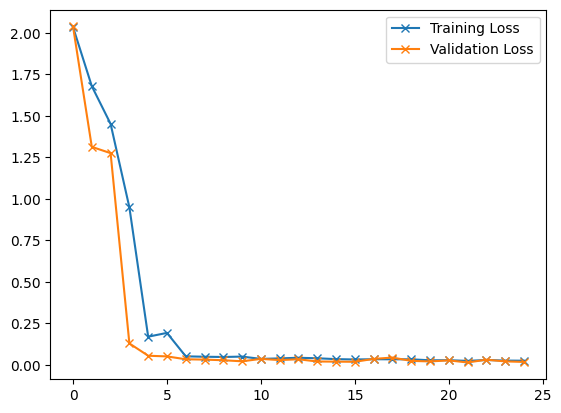

In [61]:
# Train Model with the given params.
set_seed(model_config['seed'])
params = {
    'batch_size': 8, 'shuffle': True, 'num_workers': 2
}
params['batch_size'] = best_trial.config['batch_size']
train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])

model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
# optimizer = SGD(model.parameters(), lr=0.0004, momentum=0.9)
optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
# train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=150, gpu_to_use=0)
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=model_config['epochs'], gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [62]:
print(f'Train MSE : {train_loss[-1]}, Val MSE : {validation_loss[-1]}')

Train MSE : 0.025783609052654356, Val MSE : 0.01848327099904418


In [63]:
x_data = DifferentialCombinationDataset(data, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config['allow_zero_diff'])
truth_column = []
prediction_column = []
loss_column = []
tissue_fixed_params = []

with torch.no_grad():
    for i, current_sample in enumerate(x_data):
        inputs, labels = current_sample
        inputs = inputs.view(1, -1).cuda()
        labels = labels.view(1, -1).cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Bookkeeping
        truth_column.append(labels.item())
        prediction_column.append(outputs.item())
        loss_column.append(loss.item())
        tissue_fixed_params.append(x_data.split_fixed_columns[x_data.randomized_indices_list[i]])

tissue_fixed_params = np.array(tissue_fixed_params)
truth_column = np.array(truth_column).reshape(-1, 1)
prediction_column = np.array(prediction_column).reshape(-1, 1)
loss_column = np.array(loss_column).reshape(-1, 1)

merged = np.hstack([tissue_fixed_params, truth_column, prediction_column, loss_column])
merged_df = pd.DataFrame(merged, columns=fixed_columns + ['Truth', 'Predicted', "Error"])
merged_df.head()

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Error
0,4.0,0.225,1.0,0.000000,0.104530,0.010926
1,6.0,0.475,1.0,2.828427,2.763325,0.004238
2,6.0,0.600,1.0,-0.707107,-0.601549,0.011142
3,2.0,0.350,1.0,-1.414214,-1.489019,0.005596
4,6.0,0.475,0.9,-0.707107,-0.655973,0.002615


Text(0, 0.5, 'Count')

<Figure size 640x480 with 0 Axes>

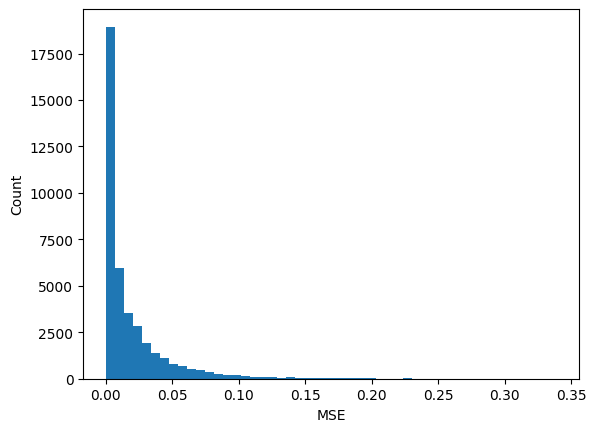

In [64]:
plt.figure()
plt.figure('Error Distribution')
plt.hist(loss_column, 50)
plt.xlabel('MSE')
plt.ylabel('Count')

In [65]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = merged_df['Error'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(merged_df.iloc[worst_errors, :])

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Error
16977,4.0,0.6,0.950,-2.828427,-2.246259,0.338920
11211,4.0,0.6,0.950,-2.828427,-2.246259,0.338920
34966,4.0,0.6,0.950,-2.828427,-2.246259,0.338920
34961,4.0,0.6,0.950,-2.828427,-2.246259,0.338920
744,6.0,0.1,0.900,2.828427,3.385938,0.310818
29919,4.0,0.6,0.950,-2.828427,-2.278057,0.302908
33096,4.0,0.6,0.975,-2.828427,-2.284390,0.295976
4810,6.0,0.1,0.900,2.828427,3.370504,0.293847
28587,4.0,0.6,1.000,-2.828427,-2.288733,0.291270
36651,6.0,0.1,0.900,2.121320,2.659400,0.289529


In [66]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [1.16026241e-05]
Validation Error(non-normalized): [8.31747195e-06]


In [67]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
SplitChannelCNN                          --
├─Conv1d: 1-1                            64
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       452
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       3
│    └─Flatten: 2-6                      --
Total params: 529
Trainable params: 529
Non-trainable params: 0